In [49]:
# Importa le librerie necessarie
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import os
import random
from skimage.util import random_noise
from os import listdir
import tarfile
import zipfile
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.data.experimental import AUTOTUNE
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Layer, Conv2D, Add, ReLU, Concatenate, GlobalAveragePooling2D, Multiply, Input, Lambda,  MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model
import tensorflow_datasets as tfds
from tensorflow.keras.saving import register_keras_serializable
from keras.models import load_model
from sklearn.model_selection import train_test_split
from io import BytesIO


In [50]:
# MeanShift: sottrae (o aggiunge) la media RGB
@register_keras_serializable("MeanShift")
class MeanShift(Layer):
    def __init__(self, rgb_mean, sign=-1, **kwargs):
        """
        rgb_mean: tupla con la media dei canali R, G, B.
        sign: -1 per sottrarre la media, 1 per aggiungerla.
        """
        super(MeanShift, self).__init__(**kwargs)
        self.rgb_mean = tf.constant(rgb_mean, dtype=tf.float32)
        self.sign = sign

    def call(self, x):
        # x è atteso in formato (batch, altezza, larghezza, 3)
        # Sfruttiamo Lambda per eseguire l'operazione per ogni elemento
        # Nota: non stiamo scalando per std in questo esempio
        return x + self.sign * self.rgb_mean

# BasicBlock: Conv2D seguita da attivazione ReLU
@register_keras_serializable("BasicBlock")
class BasicBlock(Layer):
    def __init__(self, out_channels, kernel_size=3, stride=1, use_bias=False, **kwargs):
        super(BasicBlock, self).__init__(**kwargs)
        self.conv = Conv2D(out_channels, kernel_size, strides=stride,
                           padding='same', use_bias=use_bias)
        self.relu = ReLU()

    def call(self, x):
        return self.relu(self.conv(x))

# ResidualBlock: due convoluzioni con skip connection(come lavora cuda con 2 thread -> 2 filtri applicati e poi si uniscono i risultati)
@register_keras_serializable("ResidualBlock")
class ResidualBlock(Layer):
    def __init__(self, out_channels, **kwargs):
        super(ResidualBlock, self).__init__(**kwargs)
        self.conv1 = Conv2D(out_channels, 3, strides=1, padding='same')
        self.relu = ReLU()
        self.conv2 = Conv2D(out_channels, 3, strides=1, padding='same')

    def call(self, x):
        residual = self.conv1(x)
        residual = self.relu(residual)
        residual = self.conv2(residual)
        out = Add()([x, residual])
        return ReLU()(out)

# EResidualBlock: versione estesa con convoluzioni a gruppi
@register_keras_serializable("EResidualBlock")
class EResidualBlock(Layer):
    def __init__(self, out_channels, groups=1, **kwargs):
        super(EResidualBlock, self).__init__(**kwargs)
        self.conv1 = Conv2D(out_channels, 3, strides=1, padding='same', groups=groups)
        self.relu = ReLU()
        self.conv2 = Conv2D(out_channels, 3, strides=1, padding='same', groups=groups)
        self.conv3 = Conv2D(out_channels, 1, strides=1, padding='valid')

    def call(self, x):
        residual = self.conv1(x)
        residual = self.relu(residual)
        residual = self.conv2(residual)
        residual = self.relu(residual)
        residual = self.conv3(residual)
        out = Add()([x, residual])
        return ReLU()(out)

# Merge_Run_dual: due rami convoluzionali con dilatazioni diverse, poi fusione e skip connection
@register_keras_serializable("MergeRunDual")
class MergeRunDual(Layer):
    def __init__(self, out_channels, **kwargs):
        super(MergeRunDual, self).__init__(**kwargs)
        # Primo ramo
        self.conv1a = Conv2D(out_channels, 3, strides=1, padding='same')
        self.relu1a = ReLU()
        self.conv1b = Conv2D(out_channels, 3, strides=1, padding='same', dilation_rate=2)
        self.relu1b = ReLU()
        # Secondo ramo
        self.conv2a = Conv2D(out_channels, 3, strides=1, padding='same', dilation_rate=3)
        self.relu2a = ReLU()
        self.conv2b = Conv2D(out_channels, 3, strides=1, padding='same', dilation_rate=4)
        self.relu2b = ReLU()
        # Gogeta
        self.conv3 = Conv2D(out_channels, 3, strides=1, padding='same')
        self.relu3 = ReLU()

    def call(self, x):
        branch1 = self.relu1a(self.conv1a(x))
        branch1 = self.relu1b(self.conv1b(branch1))

        branch2 = self.relu2a(self.conv2a(x))
        branch2 = self.relu2b(self.conv2b(branch2))

        merged = Concatenate()([branch1, branch2])
        merged = self.relu3(self.conv3(merged))
        return Add()([merged, x])

# CALayer: Channel Attention Layer
@register_keras_serializable("CALayer")
class CALayer(Layer):
    def __init__(self, channel, reduction=16, **kwargs):
        super(CALayer, self).__init__(**kwargs)
        self.channel = channel
        self.reduction = reduction
        self.conv1 = Conv2D(channel // reduction, 1, strides=1, padding='same')
        self.relu = ReLU()
        self.conv2 = Conv2D(channel, 1, strides=1, padding='same', activation='sigmoid') #sigmoid: risultato tra 0 e 1

    def call(self, x):
        # Calcolo della media globale per canale
        y = tf.reduce_mean(x, axis=[1, 2], keepdims=True)
        y = self.relu(self.conv1(y))
        y = self.conv2(y)
        return Multiply()([x, y])

# Block: combinazione di MergeRunDual, ResidualBlock, EResidualBlock e CALayer
@register_keras_serializable("Block")
class Block(Layer):
    def __init__(self, out_channels, **kwargs):
        super(Block, self).__init__(**kwargs)
        self.merge_run_dual = MergeRunDual(out_channels)
        self.residual_block = ResidualBlock(out_channels)
        self.e_residual_block = EResidualBlock(out_channels)
        self.ca = CALayer(out_channels)

    def call(self, x):
        r1 = self.merge_run_dual(x)
        r2 = self.residual_block(r1)
        r3 = self.e_residual_block(r2)
        out = self.ca(r3)
        return out

# RIDNET: il modello final
@register_keras_serializable("RIDNET")
def RIDNET(n_feats=64, rgb_range=1.0):
    """
    n_feats: numero di feature channels usate all'interno del modello.
    rgb_range: scala dei valori RGB (ad es. 1.0 se l'input è normalizzato [0,1]).
    """
    rgb_mean = (0.4488, 0.4371, 0.4040)

    input_layer = Input(shape=(None, None, 3))

    # Sottosottrai la media (MeanShift con sign=-1)
    sub_mean = MeanShift(rgb_mean, sign=-1)
    x = sub_mean(input_layer)

    # Testa: BasicBlock (conv + ReLU)
    head = Conv2D(n_feats, 3, strides=1, padding='same', activation='relu')(x)

    # Serie di blocchi
    b1 = Block(n_feats)(head)
    b2 = Block(n_feats)(b1)
    b3 = Block(n_feats)(b2)
    b4 = Block(n_feats)(b3)

    # Coda: convoluzione finale per ottenere 3 canali
    tail = Conv2D(3, 3, strides=1, padding='same')(b4)

    # Aggiungi la media (MeanShift con sign=+1)
    add_mean = MeanShift(rgb_mean, sign=1)
    res = add_mean(tail)

    # Connessione residua a livello di immagine: somma con l'input originale
    output = Add()([res, input_layer])

    model = Model(inputs=input_layer, outputs=output)
    return model

In [51]:
def psnr_batch(originals, denoiseds, max_pixel = 1.0):
  """
  Calcola il PSNR per ogni coppia di immagini in due batch.

  originals: np.array di shape (N, H, W, C)
  denoised: np.array di shape (N, H, W, C)
  max_pixel: valore massimo del pixel (1.0 se normalizzato, 255 per uint8)
  Ritorna:
  - lista dei PSNR (uno per immagine)
  """
  assert originals.shape == denoiseds.shape, "Shape mismatch!"
  psnrs = []
  for i in range(originals.shape[0]):
      mse = np.mean((originals[i] - denoiseds[i]) ** 2)
      if mse == 0:
          psnrs.append(float('inf'))
      else:
          psnrs.append(10 * np.log10((max_pixel ** 2) / mse))

  return psnrs



def plot_psnr(psnr_set1, psnr_set2, psnr_set3 = [], title="PSNR per immagine"):
    """
    psnr_set1: lista o lista di liste con PSNR dei denoised (es. per livello di rumore)
    psnr_set2: idem per le immagini noisy
    """
    noise_levels = [i for i in range(5, 5 * (len(psnr_set1) + 1), 5)]

    # Assicura che ogni set sia lista di liste (es. una lista per livello)
    psnr_set1 = [np.atleast_1d(p) for p in psnr_set1]
    psnr_set2 = [np.atleast_1d(p) for p in psnr_set2]
    if(len(psnr_set3) > 0):
        psnr_set3 = [np.atleast_1d(p) for p in psnr_set3]

    # Figura
    plt.figure(figsize=(10, 6) )

    # Scatter di tutti i valori
    for i, level in enumerate(noise_levels):
        plt.scatter([level]*len(psnr_set1[i]), psnr_set1[i], marker='^', s=50, c='green', alpha=0.6)
        plt.scatter([level]*len(psnr_set2[i]), psnr_set2[i], marker='o', s=50, c='red', alpha=0.4)
        if(len(psnr_set3) > 0):
          plt.scatter([level]*len(psnr_set3[i]), psnr_set3[i], marker='x', s=50, c='blue', alpha=0.4)

    # Media PSNR per livello
    avg_psnr1 = [np.mean(p) for p in psnr_set1]
    avg_psnr2 = [np.mean(p) for p in psnr_set2]
    if(len(psnr_set3) > 0):
        avg_psnr3 = [np.mean(p) for p in psnr_set3]

    # Linea media
    plt.plot(noise_levels, avg_psnr1, color='green', label='Media PSNR - Denoised', linewidth=2)
    plt.plot(noise_levels, avg_psnr2, color='red', label='Media PSNR - Noisy', linewidth=2)
    if(len(psnr_set3) > 0):
        plt.plot(noise_levels, avg_psnr3, color='blue', label='Media PSNR - Noisy +', linewidth=2)

    plt.xlabel('Noise Level')
    plt.ylabel('PSNR (dB)')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [52]:
def preprocess(sample, img_size):
    """Preprocessa le immagini: ridimensionamento e normalizzazione."""
    image = tf.image.resize(sample['image'], img_size) / 255.0  # Normalizza in [0,1]
    label = sample['label']  # Estrai l'etichetta
    return image, label

def load_simple_dataset(split='train', img_size=(256,256), batch_size=16):
    """
    Carica il dataset Oxford-IIIT Pet da tfds e applica il preprocessamento.
    Ritorna un dataset in batch.
    """
    dataset = tfds.load('oxford_iiit_pet', split=split, as_supervised=False)  # as_supervised=False per mantenere dict
    dataset = dataset.map(lambda sample: preprocess(sample, img_size))  # Preprocessing
    dataset = dataset.shuffle(1024).batch(batch_size).prefetch(tf.data.AUTOTUNE)  # Ottimizza il caricamento
    return dataset


In [53]:
def extract_kvasir_zip(zip_path, extract_path="./kvasir_seg"):
    """
    Estrae un file ZIP contenente il dataset Kvasir.
    """
    os.makedirs(extract_path, exist_ok=True)

    print("Estrazione del dataset...")
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(path=extract_path)
    print("Estrazione completata!")

def load_kvasir_images(dataset_path, img_size=(224, 224)):
    """
    Carica le immagini dal dataset estratto.
    """
    images = []

    for img in listdir(dataset_path):
        img_path = dataset_path + "/" + img
        imgs = load_img(img_path, target_size=img_size)
        img_array = img_to_array(imgs).astype('float32') / 255.0  # Normalizzazione
        images.append(img_array)

    return np.array(images)

def split_dataset(images, labels=None, test_size=0.2, val_size=0.1):
    """
    Suddivide il dataset in training, validation e test set.
    """
    # If labels are not provided, assume unsupervised learning and create dummy labels
    if labels is None:
        labels = np.zeros(len(images))  # Create dummy labels for unsupervised task

    x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=test_size, random_state=42)
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=val_size / (1 - test_size), random_state=42)

    return x_train, x_val, x_test, y_train, y_val, y_test


In [54]:
def add_random_noise(tensor_image):
    """
    Aggiunge rumore casuale a un'immagine convertendo il tensore in NumPy.
    """
    numpy_image = tensor_image.numpy()

    # Genera un noise_factor casuale tra 0.1 e 0.9
    noise_factor = np.random.uniform(0.1, 0.9)

    # Scegli il tipo di rumore
    noise_types = ['gaussian', 'salt', 'pepper', 's&p', 'speckle', 'poisson']
    noise_type = random.choice(noise_types)

    # Applica il rumore
    noisy_img = random_noise(numpy_image, mode=noise_type, clip=True) * (1 - noise_factor) + noise_factor * np.random.rand(*numpy_image.shape)

    # Converti di nuovo in tf.Tensor
    return tf.convert_to_tensor(noisy_img, dtype=tf.float32)

# Wrapper compatibile con tf.data.Dataset.map()
def add_random_noise_tf(tensor_image):
    noisy_image = tf.py_function(func=add_random_noise, inp=[tensor_image], Tout=tf.float32)

    # Impostiamo la forma esplicitamente per evitare problemi con tf.data
    noisy_image.set_shape(tensor_image.shape)

    return noisy_image  # Restituiamo solo l'immagine rumorosa

In [55]:
def plot_side_by_side(x_noisy, x_original, n=10):
    """
    Visualizza n coppie di immagini affiancando l'immagine rumorosa e quella originale per immagini a colori.
    """
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # Immagine rumorosa
        ax = plt.subplot(2, n, i+1)
        plt.imshow(x_noisy[i])
        plt.title("Rumorosa")
        plt.axis('off')

        # Immagine originale
        ax = plt.subplot(2, n, i+1+n)
        plt.imshow(x_original[i])
        plt.title("Originale")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

In [56]:

def plot_denoising_results(x_test_noisy, decoded_imgs, x_test, n=10):
    """
    Visualizza n immagini rumorose, le rispettive immagini denoised e quelle originali.
    """
    plt.figure(figsize=(20, 4))
    n = 10
    for i in range(n):
        # Immagine rumorosa
        ax = plt.subplot(3, n, i + 1)
        plt.imshow(x_test_noisy[i])
        plt.title("Rumorosa")
        plt.axis('off')
        # Immagine denoised
        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(decoded_imgs[i])
        plt.title("Denoised")
        plt.axis('off')
        # Immagine originale
        ax = plt.subplot(3, n, i + 1 + 2*n)
        plt.imshow(x_test[i])
        plt.title("Originale")
        plt.axis('off')
    plt.tight_layout()
    plt.show()



In [57]:
def plot_side_by_side(x_noisy, x_original, n=10):
    """
    Visualizza n coppie di immagini affiancando l'immagine rumorosa e quella originale per immagini a colori.
    """
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # Immagine rumorosa
        ax = plt.subplot(2, n, i+1)
        plt.imshow(x_noisy[i])
        plt.title("Rumorosa")
        plt.axis('off')

        # Immagine originale
        ax = plt.subplot(2, n, i+1+n)
        plt.imshow(x_original[i])
        plt.title("Originale")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

In [58]:
# Parametri
img_size = (112, 112)
batch_size = 20
noise_factors = [0.1, 0.2, 0.3, 0.4]
epochs = 50

# Caricamento dataset
train_ds = load_simple_dataset(split='train', img_size=img_size, batch_size=batch_size)
test_ds  = load_simple_dataset(split='test', img_size=img_size, batch_size=batch_size)

In [59]:
def add_noise(x, noise_factor=0.1):
    noise = tf.random.normal(shape=tf.shape(x), mean=0.0, stddev=1.0)
    x_noisy = x + noise_factor * noise
    return tf.clip_by_value(x_noisy, 0., 1.)  # Assicurati che i pixel restino nel range

In [60]:
train_ds_noisy = train_ds.map(lambda x, label: (add_noise(x, 0.3), x))
test_ds_noisy  = test_ds.map(lambda x, label: (add_noise(x, 0.3), x))

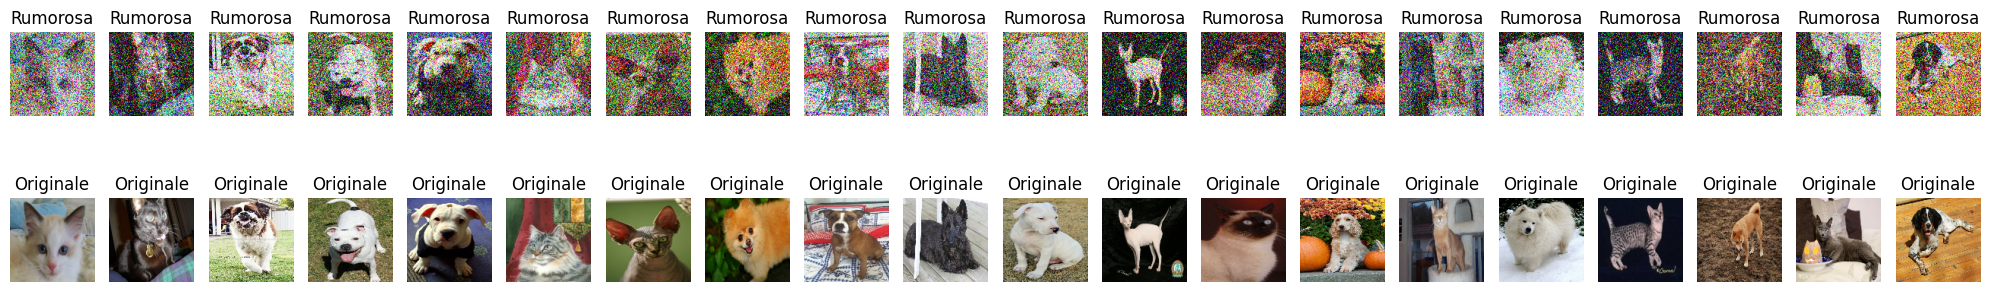

In [61]:
# Prendi un batch dal dataset (ad esempio, il primo batch)
batch = next(iter(test_ds_noisy))
x_noisy_batch, x_original_batch = batch

# Converti i tensori in array NumPy
x_noisy_np = x_noisy_batch.numpy()
x_original_np = x_original_batch.numpy()

# Usa la funzione plot_side_by_side per visualizzare n immagini
plot_side_by_side(x_noisy_np, x_original_np, n=batch_size)

In [62]:
ridnet = load_model('RIDNET_1.keras')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'block_4', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'block_5', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'block_6', however the layer does not have a `buil

In [63]:
autoencoder = load_model('/content/autencoder_1.keras')

In [64]:
ridnet_result = ridnet.predict(x_noisy_np)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


In [65]:
autoencoder_result = autoencoder.predict(x_noisy_np)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step


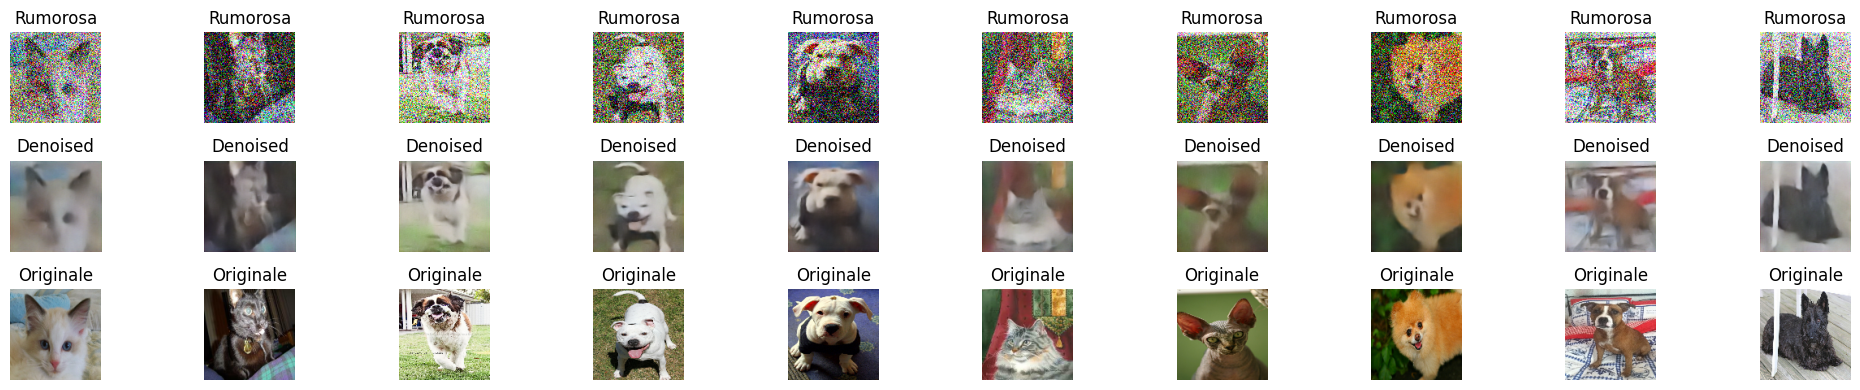

In [66]:
plot_denoising_results(x_noisy_np, ridnet_result, x_original_np, n=10)

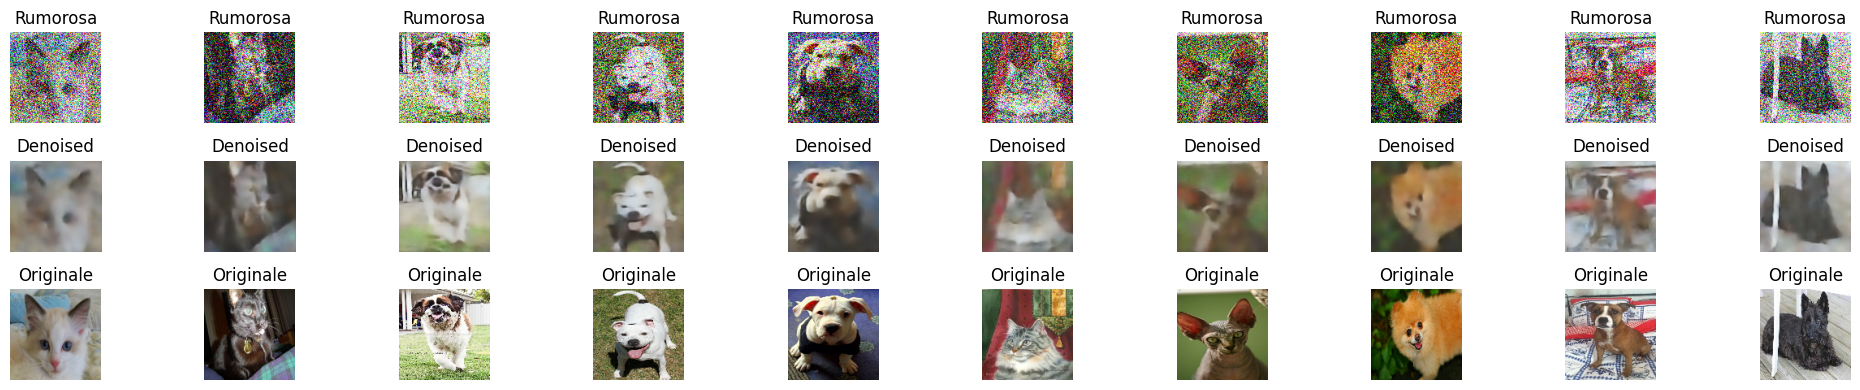

In [67]:
plot_denoising_results(x_noisy_np, autoencoder_result, x_original_np, n=10)

In [68]:


def psnr_batch(originals, denoiseds, max_pixel=1.0):
    assert originals.shape == denoiseds.shape, "Shape mismatch!"
    psnrs = []
    for i in range(originals.shape[0]):
        mse = np.mean((originals[i] - denoiseds[i]) ** 2)
        if mse == 0:
            psnrs.append(float('inf'))
        else:
            psnrs.append(10 * np.log10((max_pixel ** 2) / mse))
    return psnrs

def plot_psnr(psnr_set1, psnr_set2, psnr_set3=[], noise_levels=None, title="PSNR per immagine"):
    if noise_levels is None:
        noise_levels = [i for i in range(5, 5 * (len(psnr_set1) + 1), 5)]

    psnr_set1 = [np.atleast_1d(p) for p in psnr_set1]
    psnr_set2 = [np.atleast_1d(p) for p in psnr_set2]
    if len(psnr_set3) > 0:
        psnr_set3 = [np.atleast_1d(p) for p in psnr_set3]

    plt.figure(figsize=(10, 6))

    for i, level in enumerate(noise_levels):
        plt.scatter([level] * len(psnr_set1[i]), psnr_set1[i], marker='^', s=50, c='green', alpha=0.6)
        plt.scatter([level] * len(psnr_set2[i]), psnr_set2[i], marker='o', s=50, c='red', alpha=0.4)
        if len(psnr_set3) > 0:
            plt.scatter([level] * len(psnr_set3[i]), psnr_set3[i], marker='x', s=50, c='blue', alpha=0.4)

    avg_psnr1 = [np.mean(p) for p in psnr_set1]
    avg_psnr2 = [np.mean(p) for p in psnr_set2]
    if len(psnr_set3) > 0:
        avg_psnr3 = [np.mean(p) for p in psnr_set3]

    plt.plot(noise_levels, avg_psnr1, color='green', label='Media PSNR - Denoised', linewidth=2)
    plt.plot(noise_levels, avg_psnr2, color='red', label='Media PSNR - Noisy', linewidth=2)
    if len(psnr_set3) > 0:
        plt.plot(noise_levels, avg_psnr3, color='blue', label='Media PSNR - Altro', linewidth=2)

    plt.xlabel('Noise Factor (%)')
    plt.ylabel('PSNR (dB)')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [69]:

a_set1 = psnr_batch(x_original_np, autoencoder_result)
a_set2 = psnr_batch(x_noisy_np, autoencoder_result)


In [70]:

r_set1 = psnr_batch(x_original_np, ridnet_result)
r_set2 = psnr_batch(x_noisy_np, ridnet_result)


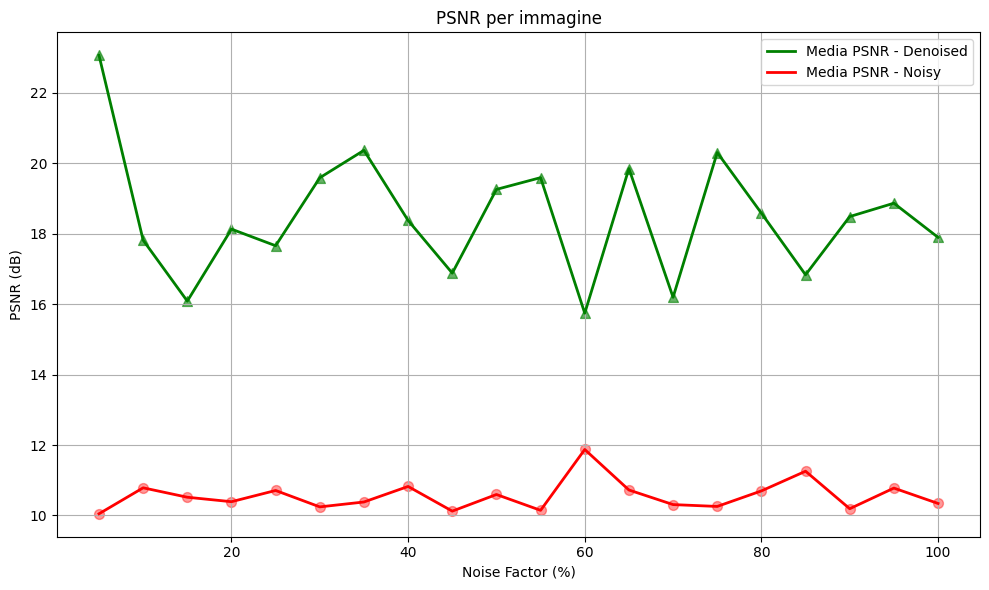

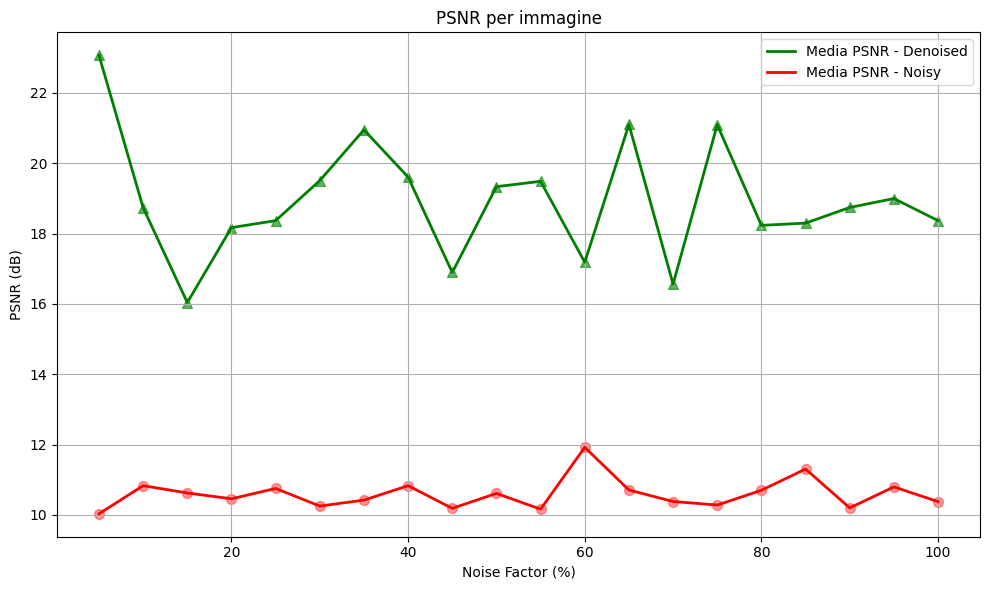

In [71]:

plot_psnr( a_set1, a_set2)
plot_psnr( r_set1, r_set2)

In [73]:
psnr_denoised_all = []
psnr_noisy_all = []

for nf in noise_factors:

    x_noisy = test_ds.map(lambda x, label: (add_noise(x, nf), x))
    decoded_imgs = autoencoder.predict(x_noisy, batch_size=batch_size)

    # Convertiamo in numpy (nel caso siano ancora tensori)
    x_noisy_np = x_noisy.numpy() if isinstance(x_noisy, tf.Tensor) else x_noisy
    decoded_np = decoded_imgs
    x_original_np = test_ds

    psnr_denoised = psnr_batch(x_original_np, decoded_np)
    psnr_noisy = psnr_batch(x_original_np, x_noisy_np)

    psnr_denoised_all.append(psnr_denoised)
    psnr_noisy_all.append(psnr_noisy)

# Plot
plot_psnr(psnr_denoised_all, psnr_noisy_all, noise_levels=[int(n * 100) for n in noise_factors])

184/184 ━━━━━━━━━━━━━━━━━━━━ 12s 54ms/step


AttributeError: '_PrefetchDataset' object has no attribute 'shape'

In [ ]:
psnr_denoised_all = []
psnr_noisy_all = []

for nf in noise_factors:
    x_noisy = test_ds.map(lambda x, label: (add_noise(x, nf), x))
    decoded_imgs = ridnet.predict(x_noisy, batch_size=batch_size)

    # Convertiamo in numpy (nel caso siano ancora tensori)
    x_noisy_np = x_noisy.numpy() if isinstance(x_noisy, tf.Tensor) else x_noisy
    decoded_np = decoded_imgs
    x_original_np = test_ds

    psnr_denoised = psnr_batch(x_original_np, decoded_np)
    psnr_noisy = psnr_batch(x_original_np, x_noisy_np)

    psnr_denoised_all.append(psnr_denoised)
    psnr_noisy_all.append(psnr_noisy)

# Plot
plot_psnr(psnr_denoised_all, psnr_noisy_all, noise_levels=[int(n * 100) for n in noise_factors])